# 한글폰트 설치
- 아래 실행후 '런터임 다시 시작' 하면 됩니다.
- 메뉴에서 '런타임' >> '런타임 다시 시작'을 클릭하세요.
- 런타임 다시 시작 후 다시 실행할 필요 없습니다.

In [183]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 로딩
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

# Install

In [1]:
!pip install sentencepiece

# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Thu Feb  4 02:22:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# data dir
data_dir = '/content/drive/MyDrive/data/data'
os.listdir(data_dir)

['ko_32000.model',
 'ko_32000.vocab',
 'kowiki',
 'mycorpus',
 '.ipynb_checkpoints',
 'my_vocab.model',
 'nsmc',
 'quora',
 'songys']

In [10]:
# songys chatbot dir
songys_dir = os.path.join(data_dir, 'songys')
if not os.path.exists(songys_dir):
    os.makedirs(songys_dir)
os.listdir(songys_dir)

['ChatbotData.csv', 'lstm.csv', 'lstm.hdf5']

# 모델링

In [11]:
# 입력 문장
#질문 2개 응답 2개~
sentences = [
    ['나는 오늘 기분이 좋아', '네가 기분이 좋으니 나도 좋아'],
    ['나는 오늘 행복해', '나도 행복하다'],
]

In [12]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
#응답일때 pair로 분리하기~
for pair in sentences:
    for sentence in pair:
        words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[BOS]': 2,
  '[EOS]': 3,
  '[PAD]': 0,
  '[UNK]': 1,
  '기분이': 6,
  '나는': 4,
  '나도': 10,
  '네가': 8,
  '오늘': 5,
  '좋아': 7,
  '좋으니': 9,
  '행복하다': 12,
  '행복해': 11},
 {0: '[PAD]',
  1: '[UNK]',
  2: '[BOS]',
  3: '[EOS]',
  4: '나는',
  5: '오늘',
  6: '기분이',
  7: '좋아',
  8: '네가',
  9: '좋으니',
  10: '나도',
  11: '행복해',
  12: '행복하다'})

In [90]:
# Question과 Answer를 숫자료
question_list, answer_list = [], []

for pair in sentences:
    question_list.append([word_to_id[word] for word in pair[0].split()])
    answer_list.append([word_to_id[word] for word in pair[1].split()])

question_list, answer_list

([[4, 5, 6, 7], [4, 5, 11]], [[8, 6, 9, 10, 7], [10, 12]])

In [91]:
# 학습용 입력 데이터 생성
train_enc_inputs, train_dec_inputs, train_labels = [], [], []

for question, answer in zip(question_list, answer_list):
    train_enc_inputs.append(question)
    train_dec_inputs.append([word_to_id['[BOS]']] + answer)
    train_labels.append(answer + [word_to_id['[EOS]']])

train_enc_inputs, train_dec_inputs, train_labels


([[4, 5, 6, 7], [4, 5, 11]],
 [[2, 8, 6, 9, 10, 7], [2, 10, 12]],
 [[8, 6, 9, 10, 7, 3], [10, 12, 3]])

In [92]:
# Encoder 입력의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_enc_inputs:
    row += [0] * (4 - len(row))

# Decoder 입력의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_dec_inputs:
    row += [0] * (6 - len(row))

# 정답의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_labels:
    row += [0] * (6 - len(row))

train_enc_inputs, train_dec_inputs, train_labels

([[4, 5, 6, 7], [4, 5, 11, 0]],
 [[2, 8, 6, 9, 10, 7], [2, 10, 12, 0, 0, 0]],
 [[8, 6, 9, 10, 7, 3], [10, 12, 3, 0, 0, 0]])

In [93]:
# numpy array로 변환
train_enc_inputs = np.array(train_enc_inputs)
train_dec_inputs = np.array(train_dec_inputs)
train_labels = np.array(train_labels)

train_enc_inputs, train_dec_inputs, train_labels

(array([[ 4,  5,  6,  7],
        [ 4,  5, 11,  0]]), array([[ 2,  8,  6,  9, 10,  7],
        [ 2, 10, 12,  0,  0,  0]]), array([[ 8,  6,  9, 10,  7,  3],
        [10, 12,  3,  0,  0,  0]]))

In [94]:
# embedding 생성
embedding = tf.keras.layers.Embedding(len(id_to_word), 5)

# word embedding
hidden_enc = embedding(train_enc_inputs)  # (bs, n_enc_seq, 5)
hidden_dec = embedding(train_dec_inputs)  # (bs, n_dec_seq, 5)
hidden_enc.shape, hidden_dec.shape

(TensorShape([2, 4, 5]), TensorShape([2, 6, 5]))

In [95]:
# Encoder LSTM (uni-direction, bi-direction 가능)
fw_cell = tf.keras.layers.LSTM(units=4, return_state=True)
bw_cell = tf.keras.layers.LSTM(units=4, go_backwards=True, return_state=True)

lstm_enc = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
hidden_enc, fw_h, fw_c, bw_h, bw_c = lstm_enc(hidden_enc)

hidden_enc.shape, fw_h.shape, fw_c.shape, bw_h.shape, bw_c.shape

(TensorShape([2, 8]),
 TensorShape([2, 4]),
 TensorShape([2, 4]),
 TensorShape([2, 4]),
 TensorShape([2, 4]))

In [96]:
# Concat hidden and cell state
s_h = K.concatenate([fw_h, bw_h], axis=-1)
s_c = K.concatenate([fw_c, bw_c], axis=-1)
s_h.shape, s_c.shape


(TensorShape([2, 8]), TensorShape([2, 8]))

In [97]:
# Decoder LSTM (uni-direction만 가능)
lstm_dec = tf.keras.layers.LSTM(units=8, return_sequences=True)
hidden_dec = lstm_dec(hidden_dec, initial_state=[s_h, s_c])
hidden_dec.shape

TensorShape([2, 6, 8])

In [99]:
# Decoder 입력의 다음단어 예측
dense_out = tf.keras.layers.Dense(units=len(id_to_word), activation=tf.nn.softmax)
outputs = dense_out(hidden_dec)
outputs.shape

TensorShape([2, 6, 13])

In [100]:
def build_model(n_vocab, d_model, n_enc_seq, n_dec_seq):
    """
    seq2seq 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_enc_seq: encoder 문장 길이 (단어 수)
    :param n_dec_seq: decoder 문장 길이 (단어 수)
    """
    inputs_enc = tf.keras.layers.Input((n_enc_seq,))  # (bs, n_enc_seq)
    inputs_dec = tf.keras.layers.Input((n_dec_seq,))  # (bs, n_dec_seq)
    ################################################
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden_enc = embedding(inputs_enc)  # (bs, n_enc_seq, d_model)
    hidden_dec = embedding(inputs_dec)  # (bs, n_dec_seq, d_model)

    # Encoder LSTM (uni-direction, bi-direction 가능)
    fw_cell = tf.keras.layers.LSTM(units=d_model, return_state=True)
    bw_cell = tf.keras.layers.LSTM(units=d_model, go_backwards=True, return_state=True)
    lstm_enc = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
    hidden_enc, fw_h, fw_c, bw_h, bw_c = lstm_enc(hidden_enc)  # (bs, d_model * 2), (bs, d_model), (bs, d_model), (bs, d_model), (bs, d_model)

    # Concatenate hidden states and cell states
    s_h = K.concatenate([fw_h, bw_h], axis=-1)  # (bs, d_model * 2)
    s_c = K.concatenate([fw_c, bw_c], axis=-1)  # (bs, d_model * 2)

    # Decoder LSTM (uni-direction만 가능)
    lstm_dec = tf.keras.layers.LSTM(units=d_model * 2, return_sequences=True)
    hidden_dec = lstm_dec(hidden_dec, initial_state=[s_h, s_c])  # (bs, n_dec_seq, d_model)
    
    # 다음단어 예측
    dense_out = tf.keras.layers.Dense(units=n_vocab, activation=tf.nn.softmax)
    outputs = dense_out(hidden_dec)  # (bs, n_dec_seq, n_vocab)
    ################################################
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=(inputs_enc, inputs_dec), outputs=outputs)
    return model

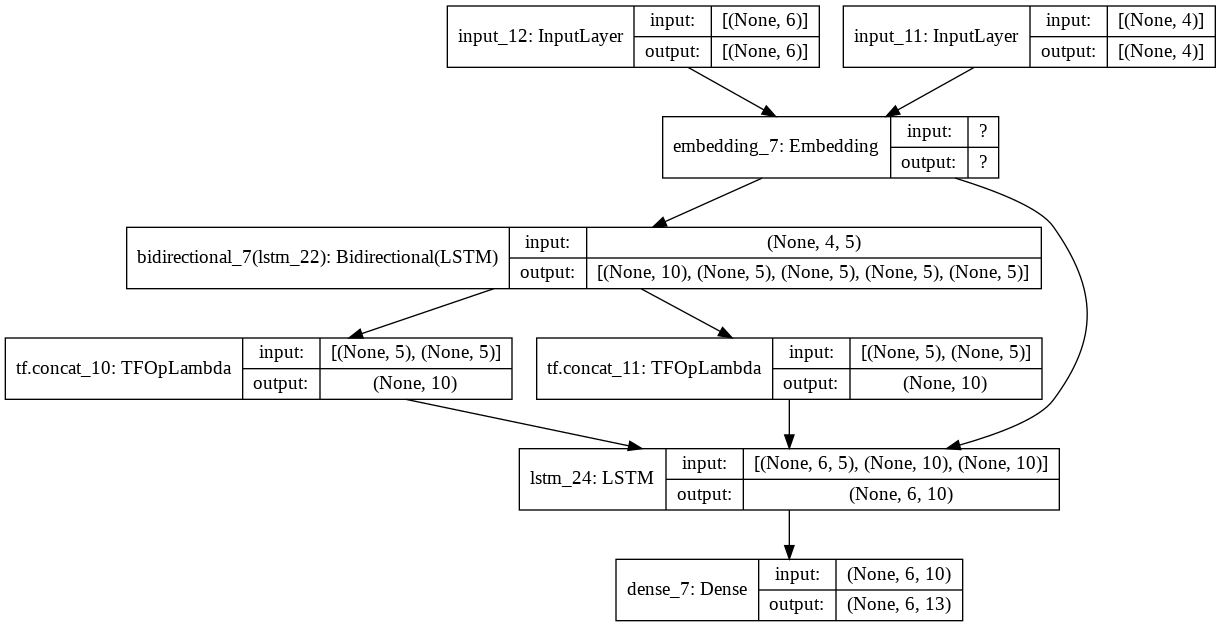

In [101]:
# 모델 생성
model = build_model(len(id_to_word), 5, 4, 6)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# 다운로드
- https://github.com/songys/Chatbot_data

In [102]:
# 파일 다운로드 및 목록 확인
!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
os.listdir('./')

--2021-02-04 02:40:00--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv [following]
--2021-02-04 02:40:00--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData .csv’

ChatbotData .csv    100%[===================>] 868.99K  --.-KB/s    in 0.02s   

2021-02-04 02:40:00 (46.2 MB/s) - ‘ChatbotData .csv’ saved [889842/889842]



['.config', 'drive', 'model.png', 'ChatbotData .csv', 'sample_data']

In [103]:
# 파일명 변경 및 목록 확인
!mv 'ChatbotData .csv' ChatbotData.csv
os.listdir('./')

['.config', 'drive', 'model.png', 'ChatbotData.csv', 'sample_data']

In [104]:
# 파일 이동
shutil.move('ChatbotData.csv', os.path.join(songys_dir, 'ChatbotData.csv'))
os.listdir(songys_dir)

['ChatbotData.csv', 'lstm.csv', 'lstm.hdf5']

# Vocabulary & config

In [105]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [106]:
n_vocab = len(vocab)  # number of vocabulary
n_enc_seq = 32  # number of sequence 1
n_dec_seq = 40  # number of sequence 2
d_model = 256  # dimension of model

# 데이터 분석

In [107]:
# train data load
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'), delimiter=',')
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [108]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


## Char

### Q

In [109]:
# char 길이 데이터
char_len = df_train['Q'].astype("str").apply(len)
char_len.head(10)

0     6
1    11
2    12
3    15
4     7
5     9
6     7
7    14
8    23
9    17
Name: Q, dtype: int64

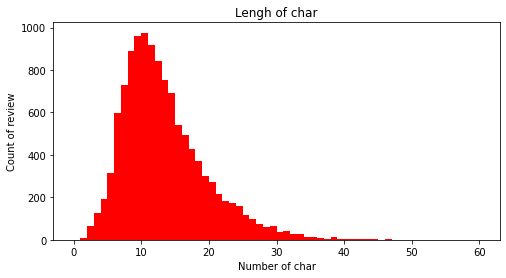

In [110]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(char_len, bins=60, range=[0, 60], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of char')
# 그래프 x 축 라벨
plt.xlabel('Number of char')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [111]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(char_len):4d}")
print(f"char 길이 최소:    {np.min(char_len):4d}")
print(f"char 길이 평균:    {np.mean(char_len):7.2f}")
print(f"char 길이 표준편차: {np.std(char_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(char_len, 25)
percentile50 = np.percentile(char_len, 50)
percentile75 = np.percentile(char_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 길이 최대:      56
char 길이 최소:       1
char 길이 평균:      12.88
char 길이 표준편차:    6.17
char 25/100분위:     9.00
char 50/100분위:    12.00
char 75/100분위:    16.00
char IQR:           7.00
char MAX/100분위:   26.50


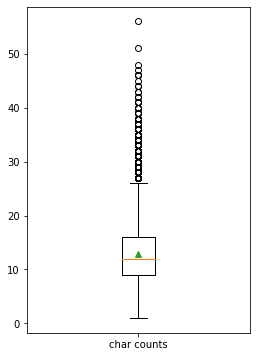

In [112]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(char_len, labels=['char counts'], showmeans=True)
plt.show()

### A

In [113]:
# char 길이 데이터
char_len = df_train['A'].astype("str").apply(len)
char_len.head(10)

0    10
1     9
2    11
3    11
4    10
5    18
6    18
7    16
8    13
9    13
Name: A, dtype: int64

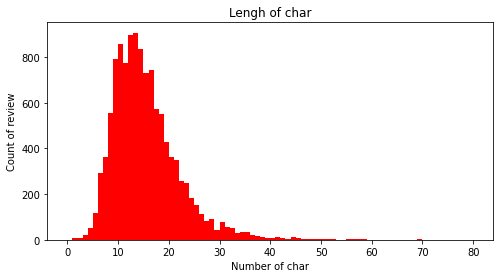

In [114]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(char_len, bins=80, range=[0, 80], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of char')
# 그래프 x 축 라벨
plt.xlabel('Number of char')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [115]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(char_len):4d}")
print(f"char 길이 최소:    {np.min(char_len):4d}")
print(f"char 길이 평균:    {np.mean(char_len):7.2f}")
print(f"char 길이 표준편차: {np.std(char_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(char_len, 25)
percentile50 = np.percentile(char_len, 50)
percentile75 = np.percentile(char_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 길이 최대:      76
char 길이 최소:       1
char 길이 평균:      15.02
char 길이 표준편차:    6.70
char 25/100분위:    10.00
char 50/100분위:    14.00
char 75/100분위:    18.00
char IQR:           8.00
char MAX/100분위:   30.00


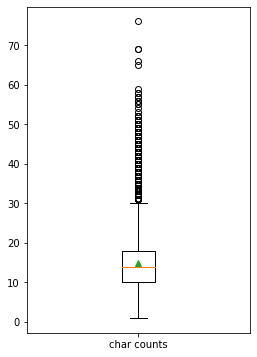

In [116]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(char_len, labels=['char counts'], showmeans=True)
plt.show()

## Word

### Q

In [117]:
# word 길이 데이터
word_len = df_train['Q'].astype(str).apply(lambda x:len(x.split(' ')))
word_len.head(10)

0    2
1    3
2    3
3    4
4    2
5    2
6    2
7    4
8    7
9    4
Name: Q, dtype: int64

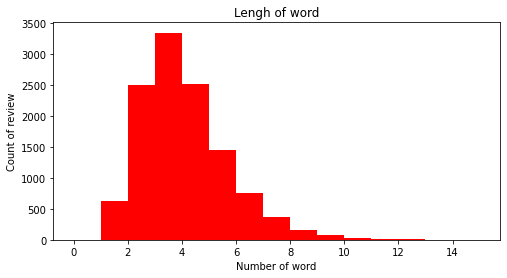

In [118]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(word_len, bins=15, range=[0, 15], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of word')
# 그래프 x 축 라벨
plt.xlabel('Number of word')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [119]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(word_len):4d}")
print(f"word 길이 최소:    {np.min(word_len):4d}")
print(f"word 길이 평균:    {np.mean(word_len):7.2f}")
print(f"word 길이 표준편차: {np.std(word_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(word_len, 25)
percentile50 = np.percentile(word_len, 50)
percentile75 = np.percentile(word_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

word 길이 최대:      15
word 길이 최소:       1
word 길이 평균:       3.59
word 길이 표준편차:    1.62
word 25/100분위:     2.00
word 50/100분위:     3.00
word 75/100분위:     4.00
word IQR:           2.00
word MAX/100분위:    7.00


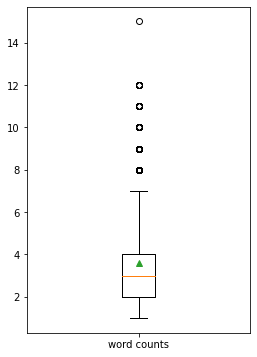

In [120]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(word_len, labels=['word counts'], showmeans=True)
plt.show()

### A

In [121]:
# word 길이 데이터
word_len = df_train['A'].astype(str).apply(lambda x:len(x.split(' ')))
word_len.head(10)

0    3
1    2
2    3
3    3
4    2
5    6
6    6
7    5
8    3
9    3
Name: A, dtype: int64

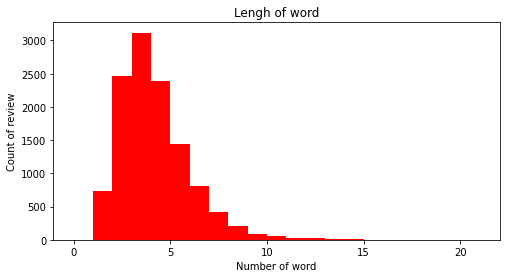

In [122]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(word_len, bins=21, range=[0, 21], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of word')
# 그래프 x 축 라벨
plt.xlabel('Number of word')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [123]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(word_len):4d}")
print(f"word 길이 최소:    {np.min(word_len):4d}")
print(f"word 길이 평균:    {np.mean(word_len):7.2f}")
print(f"word 길이 표준편차: {np.std(word_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(word_len, 25)
percentile50 = np.percentile(word_len, 50)
percentile75 = np.percentile(word_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

word 길이 최대:      21
word 길이 최소:       1
word 길이 평균:       3.69
word 길이 표준편차:    1.86
word 25/100분위:     2.00
word 50/100분위:     3.00
word 75/100분위:     5.00
word IQR:           3.00
word MAX/100분위:    9.50


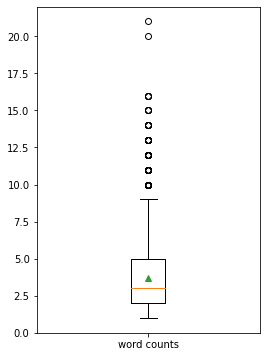

In [124]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(word_len, labels=['word counts'], showmeans=True)
plt.show()

## SentencePiece

### Q

In [125]:
# word 길이 데이터
spm_len = df_train['Q'].astype(str).apply(lambda x:len(vocab.encode_as_pieces(x)))
spm_len.head(10)

0     5
1     6
2     9
3    10
4     5
5     6
6     4
7     7
8    11
9     9
Name: Q, dtype: int64

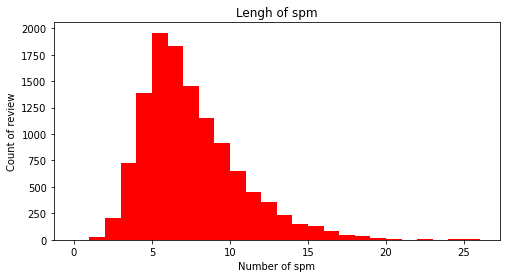

In [126]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(spm_len, bins=26, range=[0, 26], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of spm')
# 그래프 x 축 라벨
plt.xlabel('Number of spm')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [127]:
# 데이터 길이
print(f"spm 길이 최대:    {np.max(spm_len):4d}")
print(f"spm 길이 최소:    {np.min(spm_len):4d}")
print(f"spm 길이 평균:    {np.mean(spm_len):7.2f}")
print(f"spm 길이 표준편차: {np.std(spm_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(spm_len, 25)
percentile50 = np.percentile(spm_len, 50)
percentile75 = np.percentile(spm_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"spm 25/100분위:  {percentile25:7.2f}")
print(f"spm 50/100분위:  {percentile50:7.2f}")
print(f"spm 75/100분위:  {percentile75:7.2f}")
print(f"spm IQR:        {percentileIQR:7.2f}")
print(f"spm MAX/100분위: {percentileMAX:7.2f}")

spm 길이 최대:      26
spm 길이 최소:       1
spm 길이 평균:       7.00
spm 길이 표준편차:    3.09
spm 25/100분위:     5.00
spm 50/100분위:     6.00
spm 75/100분위:     9.00
spm IQR:           4.00
spm MAX/100분위:   15.00


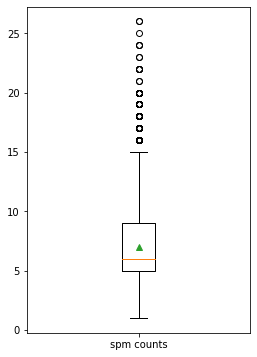

In [128]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(spm_len, labels=['spm counts'], showmeans=True)
plt.show()

### A

In [129]:
# word 길이 데이터
spm_len = df_train['A'].astype(str).apply(lambda x:len(vocab.encode_as_pieces(x)))
spm_len.head(10)

0    6
1    6
2    6
3    6
4    8
5    9
6    9
7    7
8    6
9    6
Name: A, dtype: int64

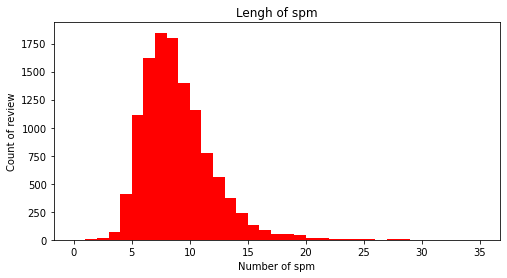

In [130]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(spm_len, bins=35, range=[0, 35], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of spm')
# 그래프 x 축 라벨
plt.xlabel('Number of spm')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [131]:
# 데이터 길이
print(f"spm 길이 최대:    {np.max(spm_len):4d}")
print(f"spm 길이 최소:    {np.min(spm_len):4d}")
print(f"spm 길이 평균:    {np.mean(spm_len):7.2f}")
print(f"spm 길이 표준편차: {np.std(spm_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(spm_len, 25)
percentile50 = np.percentile(spm_len, 50)
percentile75 = np.percentile(spm_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"spm 25/100분위:  {percentile25:7.2f}")
print(f"spm 50/100분위:  {percentile50:7.2f}")
print(f"spm 75/100분위:  {percentile75:7.2f}")
print(f"spm IQR:        {percentileIQR:7.2f}")
print(f"spm MAX/100분위: {percentileMAX:7.2f}")

spm 길이 최대:      35
spm 길이 최소:       1
spm 길이 평균:       8.44
spm 길이 표준편차:    3.06
spm 25/100분위:     6.00
spm 50/100분위:     8.00
spm 75/100분위:    10.00
spm IQR:           4.00
spm MAX/100분위:   16.00


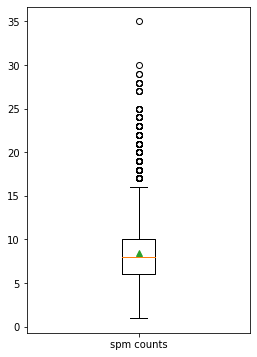

In [132]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(spm_len, labels=['spm counts'], showmeans=True)
plt.show()

## Word Cloud

In [133]:
# data 합치기
train_set = pd.Series(df_train['Q'].tolist() + df_train['A'].tolist()).astype(str)
train_set.head(10)

0                     12시 땡!
1                1지망 학교 떨어졌어
2               3박4일 놀러가고 싶다
3            3박4일 정도 놀러가고 싶다
4                    PPL 심하네
5                  SD카드 망가졌어
6                    SD카드 안돼
7             SNS 맞팔 왜 안하지ㅠㅠ
8    SNS 시간낭비인 거 아는데 매일 하는 중
9          SNS 시간낭비인데 자꾸 보게됨
dtype: object

In [134]:
# train review documents
train_review = [review for review in train_set if type(review) is str]
train_review[:10]

['12시 땡!',
 '1지망 학교 떨어졌어',
 '3박4일 놀러가고 싶다',
 '3박4일 정도 놀러가고 싶다',
 'PPL 심하네',
 'SD카드 망가졌어',
 'SD카드 안돼',
 'SNS 맞팔 왜 안하지ㅠㅠ',
 'SNS 시간낭비인 거 아는데 매일 하는 중',
 'SNS 시간낭비인데 자꾸 보게됨']

In [135]:
' '.join(train_review[:10])

'12시 땡! 1지망 학교 떨어졌어 3박4일 놀러가고 싶다 3박4일 정도 놀러가고 싶다 PPL 심하네 SD카드 망가졌어 SD카드 안돼 SNS 맞팔 왜 안하지ㅠㅠ SNS 시간낭비인 거 아는데 매일 하는 중 SNS 시간낭비인데 자꾸 보게됨'

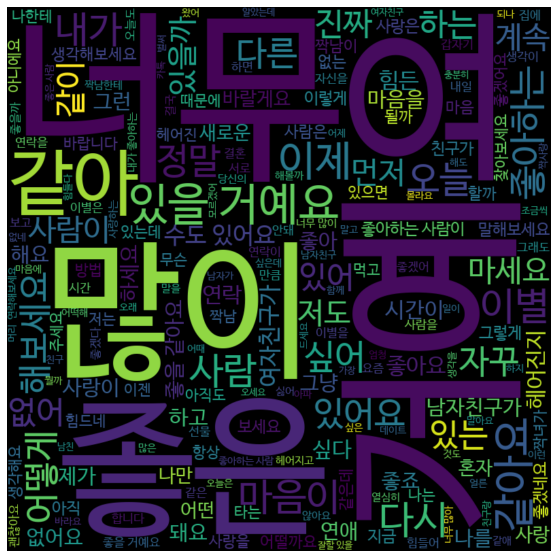

In [136]:
# WordCloud
# window: C:/Windows/Fonts/malgun.ttf, mac: /Library/Fonts/AppleGothic.ttf, colab: /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(' '.join(train_review))
plt.figure(figsize=(10, 10))
# https://datascienceschool.net/view-notebook/6e71dbff254542d9b0a054a7c98b34ec/
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Loss & Acc

In [139]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

In [140]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

# Sample Data Project

## Data


In [141]:
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'))
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [142]:
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [143]:
# 랜덤하게 10개만 확인
df_train = df_train.sample(10)
df_train

,Q,A,label
4937,피해는 주지 말아야되는 거 아니야?,남에게 피해주지 않는 건 기본이죠.,0
6156,또 다시 이별,또 다시 사랑,1
114,건강한 다이어트법,적게 먹고 많이 움직이세요.,0
10039,상대방의 마음을 사로잡는 방법,우연을 가장해서 여러 번 마주쳐보세요.,2
4480,첫인상에서 강렬한 인상 남기기,처음 3초가 중요해요. 당신의 매력을 어필해보세요.,0
2070,변기 막혔어,얼른 뚫어보아요.,0
1644,먼지가 많나,오늘 미세먼지가 많데요.,0
5399,6살 많은 전여친이랑 만나고 얘기 잘하고 왔습니다.,이야기가 잘 풀렸다니 다행이에요.,1
10656,여자친구와 노래방을 가면 무슨 노래를 부르는게 좋을까?,여자친구가 좋아하는 가수의 노래 연습해 보세요.,2
11084,좋아하는 사람 생기면 자꾸 따라하게 돼.,자연스러운 현상입니다.,2


In [144]:
def load_data(df, n_enc_seq, n_dec_seq):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    n_enc_max = n_enc_seq  # no addtional tag
    n_dec_max = n_dec_seq - 1  # [BOS] or [EOS]
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        print()
        ###########################################
        Q = row['Q']
        A = row['A']
        print(Q, '/', A)

        tokens_q = vocab.encode_as_pieces(Q)
        print(len(tokens_q), ':', tokens_q)
        tokens_a = vocab.encode_as_pieces(A)
        print(len(tokens_a), ':', tokens_a)
        # token id 생성
        tokens_ids_q = vocab.encode_as_ids(Q)[:n_enc_max]
        print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_ids_a = vocab.encode_as_ids(A)[:n_dec_max]
        print(len(tokens_ids_a), ':', tokens_ids_a)
        # decoder 입력 출력 생성
        tokens_dec_in = [vocab.bos_id()] + tokens_ids_a
        tokens_dec_out = tokens_ids_a + [vocab.eos_id()]
        # encoder 입력, dec 입력, dec 출력에 pad 추가
        tokens_ids_q += [0] * (n_enc_seq - len(tokens_ids_q))
        print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_dec_in += [0] * (n_dec_seq - len(tokens_dec_in))
        print(len(tokens_dec_in), ':', tokens_dec_in)
        tokens_dec_out += [0] * (n_dec_seq - len(tokens_dec_out))
        print(len(tokens_dec_out), ':', tokens_dec_out)
        # 값 저장
        enc_inputs[index] = tokens_ids_q
        dec_inputs[index] = tokens_dec_in
        labels[index] = tokens_dec_out
        index += 1
        ###########################################
    return enc_inputs, dec_inputs, labels

In [ ]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, n_enc_seq, n_dec_seq)
train_enc_inputs, train_dec_inputs, train_labels

## 학습

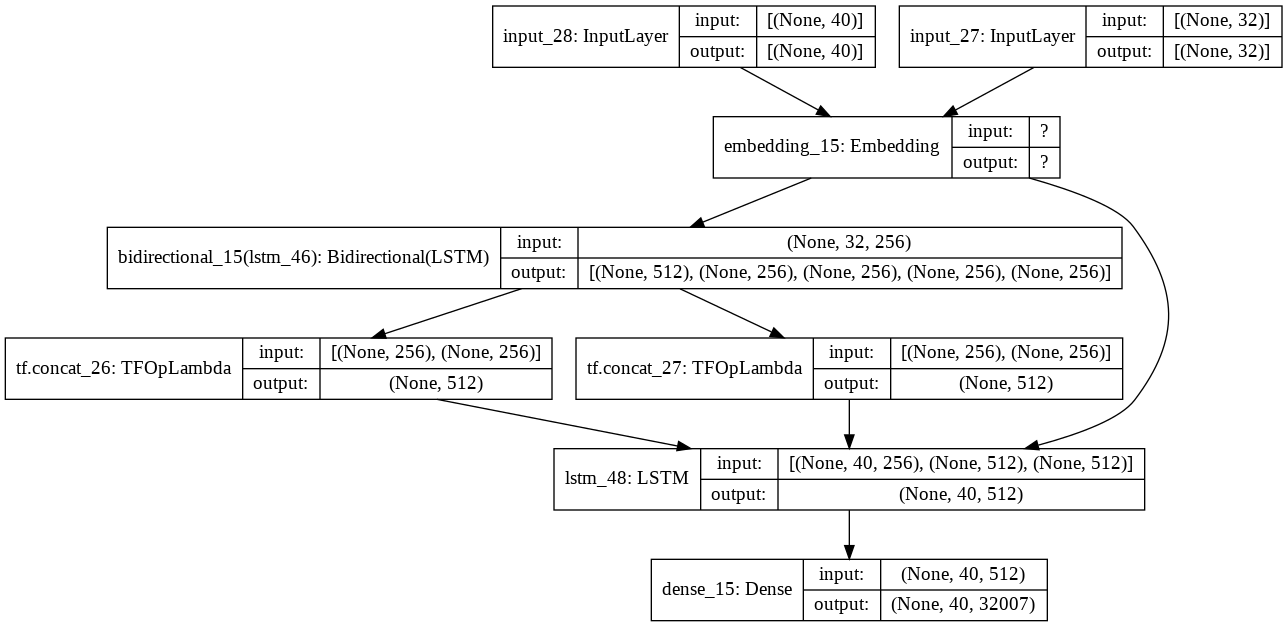

In [184]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [185]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [186]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=100)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(songys_dir, 'lstm.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(songys_dir, 'lstm.csv'))

In [187]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    epochs=400,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/400
1/1 [==============================] - 4s 4s/step - loss: 2.5934 - lm_acc: 0.0000e+00

Epoch 00001: lm_acc improved from -inf to 0.00000, saving model to /content/drive/MyDrive/data/data/songys/lstm.hdf5
Epoch 2/400
1/1 [==============================] - 0s 125ms/step - loss: 2.5919 - lm_acc: 0.2600

Epoch 00002: lm_acc improved from 0.00000 to 0.26000, saving model to /content/drive/MyDrive/data/data/songys/lstm.hdf5
Epoch 3/400
1/1 [==============================] - 0s 132ms/step - loss: 2.5899 - lm_acc: 0.2300

Epoch 00003: lm_acc did not improve from 0.26000
Epoch 4/400
1/1 [==============================] - 0s 127ms/step - loss: 2.5865 - lm_acc: 0.2100

Epoch 00004: lm_acc did not improve from 0.26000
Epoch 5/400
1/1 [==============================] - 0s 135ms/step - loss: 2.5787 - lm_acc: 0.1400

Epoch 00005: lm_acc did not improve from 0.26000
Epoch 6/400
1/1 [==============================] - 0s 115ms/step - loss: 2.5577 - lm_acc: 0.1100

Epoch 00006: lm_acc did not

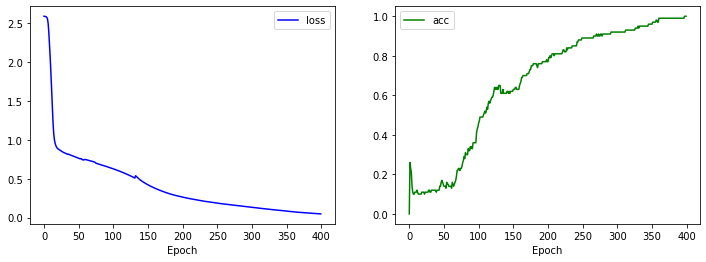

In [188]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [189]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# train weight로 초기화
model.load_weights(os.path.join(songys_dir, 'lstm.hdf5'))

In [191]:
def do_chat(vocab, model, n_enc_seq, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    #####################################
    # qeustion
    q = vocab.encode_as_pieces(string)
    print(q)
    q_id = vocab.encode_as_ids(string)[:n_enc_seq]
    q_id += [0] * (n_enc_seq - len(q_id))
    print(len(q_id), q_id)
    assert len(q_id) == n_enc_seq

    # answer
    a_id = [vocab.bos_id()]
    a_id += [0] * (n_dec_seq - len(a_id))
    print(len(a_id), a_id)
    assert len(a_id) == n_dec_seq

    # 처음부터 예측
    start_idx = 0


    for _ in range(0, 5):
        # 다음단어 예측
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        # print(outputs.shape)
        prob = outputs[0][start_idx]
        word_id = int(np.argmax(prob))
        # print(prob[word_id - 5:word_id + 5])
        # eos면 종료
        if word_id == vocab.eos_id():
            break
        a_id[start_idx + 1] = word_id
        start_idx += 1

    # 예측된 문장 생성
    predict_id = a_id[1:start_idx + 1]
    print(predict_id)
    predict_str = vocab.decode_ids(predict_id)
    return predict_str
      
    #####################################

In [192]:
string = '너는 누구니'
do_chat(vocab, model, n_enc_seq, n_dec_seq, string)

['▁너', '는', '▁누구', '니']
32 [5103, 11, 8214, 213, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
40 [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[626, 38, 422, 19, 742]


'처음 3초가 않는'

In [193]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, n_enc_seq, n_dec_seq, string)
    print(f'답변 > {predict_str}')

질문 > 피곤해
['▁피', '곤', '해']
32 [419, 2038, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
40 [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[15976, 10033, 522, 11043, 15319]
답변 > 적게 먹고 많이 움직이세요
질문 > 다른 말 해봐
['▁다른', '▁말', '▁해', '봐']
32 [93, 335, 210, 15346, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
40 [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[15976, 10033, 522, 11043, 15319]
답변 > 적게 먹고 많이 움직이세요
질문 > 


# All Data Project

## Data


In [194]:
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'))
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [195]:
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [196]:
def load_data(df, n_enc_seq, n_dec_seq):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        Q = row['Q']
        A = row['A']
        # print(Q, '/', A)

        tokens_q = vocab.encode_as_pieces(Q)
        # print(len(tokens_q), ':', tokens_q)
        tokens_a = vocab.encode_as_pieces(A)
        # print(len(tokens_a), ':', tokens_a)

        tokens_ids_q = vocab.encode_as_ids(Q)
        # print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_ids_a = vocab.encode_as_ids(A)
        # print(len(tokens_ids_a), ':', tokens_ids_a)

        tokens_ids_q = tokens_ids_q[:n_enc_max]
        # print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_ids_a = tokens_ids_a[:n_dec_max]
        # print(len(tokens_ids_a), ':', tokens_ids_a)

        tokens_dec_in = [vocab.bos_id()] + tokens_ids_a
        tokens_dec_out = tokens_ids_a + [vocab.eos_id()]

        tokens_ids_q += [0] * (n_enc_seq - len(tokens_ids_q))
        # print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_dec_in += [0] * (n_dec_seq - len(tokens_dec_in))
        # print(len(tokens_dec_in), ':', tokens_dec_in)
        tokens_dec_out += [0] * (n_dec_seq - len(tokens_dec_out))
        # print(len(tokens_dec_out), ':', tokens_dec_out)

        enc_inputs[index] = tokens_ids_q
        dec_inputs[index] = tokens_dec_in
        labels[index] = tokens_dec_out
        index += 1
    return enc_inputs, dec_inputs, labels

In [197]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, n_enc_seq, n_dec_seq)
train_enc_inputs, train_dec_inputs, train_labels

(array([[   89,    56,    10, ...,     0,     0,     0],
        [   35,    47,  1004, ...,     0,     0,     0],
        [   38,   819,   362, ...,     0,     0,     0],
        ...,
        [ 2886,  9525, 21930, ...,     0,     0,     0],
        [10736,  8256,  1172, ...,     0,     0,     0],
        [26128,    70,  1381, ...,     0,     0,     0]], dtype=int32),
 array([[    2,  2261,    19, ...,     0,     0,     0],
        [    2,  4594,    61, ...,     0,     0,     0],
        [    2,  2350,    18, ...,     0,     0,     0],
        ...,
        [    2,  1522,     1, ...,     0,     0,     0],
        [    2,   441, 10316, ...,     0,     0,     0],
        [    2, 16665,    90, ...,     0,     0,     0]], dtype=int32),
 array([[ 2261,    19,   375, ...,     0,     0,     0],
        [ 4594,    61,   929, ...,     0,     0,     0],
        [ 2350,    18,  9001, ...,     0,     0,     0],
        ...,
        [ 1522,     1, 12273, ...,     0,     0,     0],
        [  441, 103

In [198]:
train_enc_inputs.shape, train_dec_inputs.shape, train_labels.shape

((11823, 32), (11823, 40), (11823, 40))

## 학습

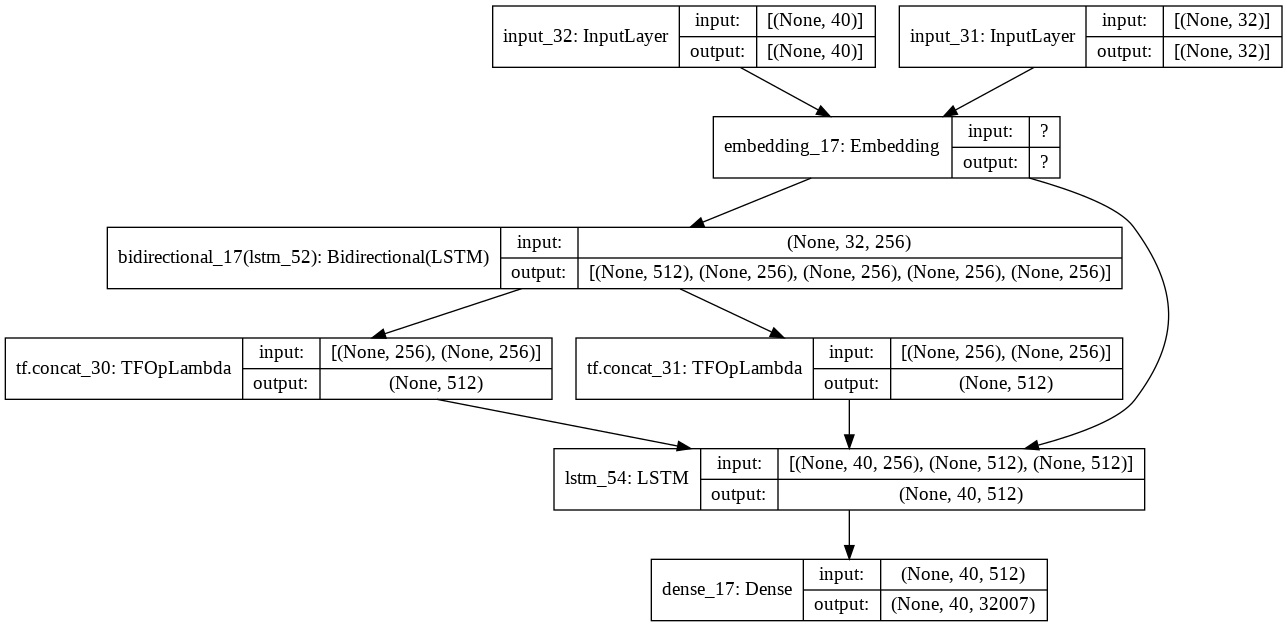

In [199]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [200]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [201]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=10)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(songys_dir, 'lstm.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(songys_dir, 'lstm.csv'))

In [202]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
47/47 [==============================] - 27s 491ms/step - loss: 1.9489 - lm_acc: 0.1199

Epoch 00001: lm_acc improved from -inf to 0.11535, saving model to /content/drive/MyDrive/data/data/songys/lstm.hdf5
Epoch 2/100
47/47 [==============================] - 24s 502ms/step - loss: 1.3116 - lm_acc: 0.1249

Epoch 00002: lm_acc improved from 0.11535 to 0.12658, saving model to /content/drive/MyDrive/data/data/songys/lstm.hdf5
Epoch 3/100
47/47 [==============================] - 24s 510ms/step - loss: 1.2836 - lm_acc: 0.1315

Epoch 00003: lm_acc improved from 0.12658 to 0.13615, saving model to /content/drive/MyDrive/data/data/songys/lstm.hdf5
Epoch 4/100
47/47 [==============================] - 25s 535ms/step - loss: 1.2317 - lm_acc: 0.1857

Epoch 00004: lm_acc improved from 0.13615 to 0.22417, saving model to /content/drive/MyDrive/data/data/songys/lstm.hdf5
Epoch 5/100
47/47 [==============================] - 26s 547ms/step - loss: 1.1454 - lm_acc: 0.2768

Epoch 00005: lm_ac

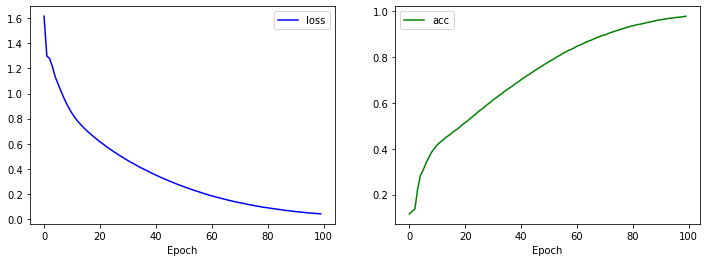

In [203]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [204]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# train weight로 초기화
model.load_weights(os.path.join(songys_dir, 'lstm.hdf5'))

In [205]:
def do_chat(vocab, model, n_enc_seq, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string)
    q_id = [vocab.piece_to_id(p) for p in q][:n_enc_seq]
    q_id += [0] * (n_enc_seq - len(q_id))
    assert len(q_id) == n_enc_seq

    # answer
    a_id = [vocab.bos_id()]
    a_id += [0] * (n_dec_seq - len(a_id))
    assert len(a_id) == n_dec_seq

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec_seq - 1):
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        a_id[start_idx + 1] = int(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [207]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, n_enc_seq, n_dec_seq, string)
    print(f'답변 > {predict_str}')

질문 > 큐브해도 돼?
답변 > 원하는 게 가장 다 먹니까요.
질문 > 오늘 좋은 옵션이 뜰까요?
답변 > 끝을 아는 것도 중요한 것 같아요.
질문 > 메이플알아?
답변 > 동감입니다.
질문 > 오늘 레전드리를 갈 수 있을까?
답변 > 제가 당신을 더 소중해요.
질문 > 알겠어
답변 > 언젠가 다 밝혀지기 마련이죠.
질문 > 뭐를 알아
답변 > 저도 궁금하네요.
질문 > 메이플하고 싶어
답변 > 오늘도 잘해보세요.
질문 > 게임하고싶어
답변 > 게임하세요!
질문 > 공부는 하기 싫어
답변 > 다음에는 받을 수 있을 거예요.
질문 > 뭘 받을 수 있어
답변 > 축하드려요!
질문 > 달력사야해
답변 > 마음 먹은 대로 되지 않아요.
질문 > 이사도 해야해
답변 > 사랑에 나이는 중요하지 않다고 생각해요.
질문 > ㅠㅠ
답변 > 되도록 만나지 마세요.
질문 > ㅋㅋ
답변 > 저는 버리는게 좋아요.
질문 > ㅇㅇ
답변 > 지금도 늦지 않았어요.
질문 > ㅡㅡ
답변 > 지금도 늦지 않았어요.
질문 > ;;
답변 > 지금은 힘들겠지만 잘 버텨보세요.
질문 > 개행문자
답변 > 새로운 인연이 거기까지인가봐요.
질문 > ㄷ한민국
답변 > 깔끔해질 거예요.
질문 > 대한민국에서 살아가기
답변 > 요즘 하우스웨딩으로 잊는 건 없답니다.
질문 > 
